# Training a Jet Tagging with **Conv2D** 

---
In this notebook, we perform a Jet identification task using a Conv2D multiclass classifier.
The problem consists in identifying a given jet as a quark, a gluon, a W, a Z, or a top,
based on a jet image, i.e., a 2D histogram of the transverse momentum ($p_T$) deposited in each of 100x100
bins of a square window of the ($\eta$, $\phi$) plane, centered along the jet axis.

For details on the physics problem, see https://arxiv.org/pdf/1804.06913.pdf 

For details on the dataset, see Notebook1

---

In [13]:
import os
import h5py
import glob
import numpy as np
import matplotlib.pyplot as plt

In [14]:
%matplotlib inline

# Preparation of the training and validation samples

---
In order to import the dataset, we now
- clone the dataset repository (to import the data in Colab)
- load the h5 files in the data/ repository
- extract the data we need: a target and jetImage 

To type shell commands, we start the command line with !

In [15]:
! git clone https://github.com/pierinim/tutorials.git

Cloning into 'tutorials'...
remote: Enumerating objects: 702, done.
remote: Counting objects: 100% (123/123), done.
remote: Compressing objects: 100% (85/85), done.
^Cceiving objects:  12% (91/702), 620.01 KiB | 183.00 KiB/s
fetch-pack: unexpected disconnect while reading sideband packet


In [16]:
! ls tutorials/Data/JetDataset/

jetImage_7_100p_0_10000.h5     jetImage_7_100p_50000_60000.h5
jetImage_7_100p_10000_20000.h5 jetImage_7_100p_60000_70000.h5
jetImage_7_100p_30000_40000.h5 jetImage_7_100p_70000_80000.h5
jetImage_7_100p_40000_50000.h5 jetImage_7_100p_80000_90000.h5


In [20]:
target = np.array([])
jetImage = np.array([])
# we cannot load all data on Colab. So we just take a few files
datafiles = ['tutorials/Data/JetDataset/jetImage_7_100p_30000_40000.h5',
            'tutorials/Data/JetDataset/jetImage_7_100p_60000_70000.h5',
            'tutorials/Data/JetDataset/jetImage_7_100p_50000_60000.h5',
            'tutorials/Data/JetDataset/jetImage_7_100p_10000_20000.h5',
            'tutorials/Data/JetDataset/jetImage_7_100p_0_10000.h5']
for fileIN in datafiles:
    print("Appending %s" %fileIN)
    f = h5py.File(fileIN)
    myjetImage = np.array(f.get("jetImage"))
    mytarget = np.array(f.get('jets')[0:,-6:-1])
    jetImage = np.concatenate([jetImage, myjetImage], axis=0) if jetImage.size else myjetImage
    target = np.concatenate([target, mytarget], axis=0) if target.size else mytarget
    f.close()
print(target.shape, jetImage.shape)

#jetImage = jetImage/jetImage.max()

Appending ../../tutorials/Data/JetDataset/jetImage_7_100p_30000_40000.h5
Appending ../../tutorials/Data/JetDataset/jetImage_7_100p_60000_70000.h5
Appending ../../tutorials/Data/JetDataset/jetImage_7_100p_50000_60000.h5
Appending ../../tutorials/Data/JetDataset/jetImage_7_100p_10000_20000.h5
Appending ../../tutorials/Data/JetDataset/jetImage_7_100p_0_10000.h5
(50000, 5) (50000, 100, 100)


# Display average images for the five classes

The dataset consists of 50000 with up to 100 particles in each jet. These 100 particles have been used to fill the 100x100 jet images.

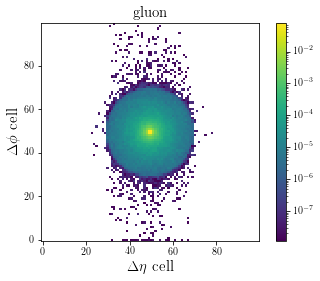

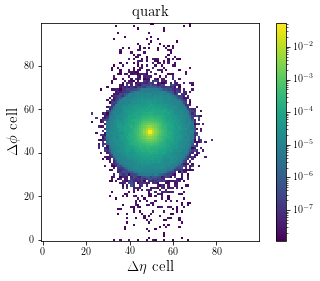

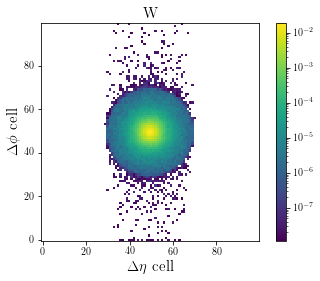

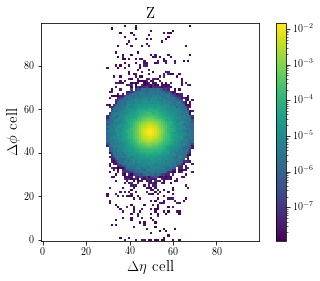

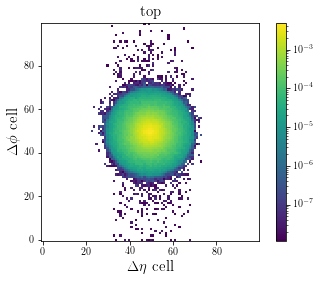

In [22]:
from matplotlib.colors import LogNorm
labelCat= ["gluon", "quark", "W", "Z", "top"]
image_g = jetImage[np.argmax(target, axis=1) == 0]
image_q = jetImage[np.argmax(target, axis=1) == 1]
image_W = jetImage[np.argmax(target, axis=1) == 2]
image_Z = jetImage[np.argmax(target, axis=1) == 3]
image_t = jetImage[np.argmax(target, axis=1) == 4]
images = [image_q, image_g, image_W, image_Z, image_t]
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
for i in range(len(images)):
    SUM_Image = np.sum(images[i], axis = 0)
    plt.imshow(SUM_Image/float(images[i].shape[0]), origin='lower',norm=LogNorm())
    plt.colorbar()
    plt.title(labelCat[i], fontsize=15)
    plt.xlabel("$\Delta\eta$ cell", fontsize=15)
    plt.ylabel("$\Delta\phi$ cell", fontsize=15)
    plt.show()

# Prepare X and Y datasets

We now shuffle the data, splitting them into a training and a validation dataset with 2:1 ratio

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(jetImage, target, test_size=0.33)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)
del jetImage, target

(33500, 100, 100) (16500, 100, 100) (33500, 5) (16500, 5)


In keras, images are representable as $n \times m \times k$ tensors, where $n \times m$ are the pixel dimenions and $k$ is the number of channels (e.g., 1 in a black\&while image, 3 for an RGB image). In our case, k=1. To comply to this, we add the channel index by reshaping the image dataset

In [8]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], X_val.shape[2], 1))
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(33500, 100, 100, 1) (16500, 100, 100, 1) (33500, 5) (16500, 5)


# Conv 2D model building

In [11]:
# keras imports
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Conv2D, Dropout, Flatten
from tensorflow.keras.layers import MaxPooling2D, AveragePooling2D, BatchNormalization, Activation
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
from tensorflow.keras import metrics
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TerminateOnNaN

In [10]:
img_rows = X_train.shape[1]
img_cols = X_train.shape[2]
dropoutRate = 0.25

In [ ]:
image_shape = (img_rows, img_cols, 1)
####
inputImage = Input(shape=(image_shape))

# COMPLETE MODEL 

#x = Conv2D(5, kernel_size=(5,5), data_format="channels_last", strides=(1, 1), padding="same")(inputImage)
#x = Activation('relu')(x)
#x = MaxPooling2D( pool_size = (5,5))(x)

output = Dense(5, activation='softmax')(x)
####
model = Model(inputs=inputImage, outputs=output)

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.summary()

We now train the model

In [ ]:
batch_size = 128
n_epochs = 200

In [ ]:
# train 
history = model.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size, verbose = 2,
                validation_data=(X_val, y_val),
                callbacks = [
                EarlyStopping(monitor='val_loss', patience=10, verbose=1),
                ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1),
                TerminateOnNaN()])

In [ ]:
# plot training history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.yscale('log')
plt.title('Training History')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

# Building the ROC Curves

In [ ]:
labels = ['gluon', 'quark', 'W', 'Z', 'top']

In [ ]:
import pandas as pd
from sklearn.metrics import roc_curve, auc
predict_val = model.predict(X_val)
df = pd.DataFrame()
fpr = {}
tpr = {}
auc1 = {}

plt.figure()
for i, label in enumerate(labels):
        df[label] = y_val[:,i]
        df[label + '_pred'] = predict_val[:,i]

        fpr[label], tpr[label], threshold = roc_curve(df[label],df[label+'_pred'])

        auc1[label] = auc(fpr[label], tpr[label])

        plt.plot(tpr[label],fpr[label],label='%s tagger, auc = %.1f%%'%(label,auc1[label]*100.))
plt.semilogy()
plt.xlabel("TPR")
plt.ylabel("FPR")
plt.ylim(0.000001,1)
plt.grid(True)
plt.legend(loc='lower right')
plt.show()